<a href="https://colab.research.google.com/github/nitrogenlab/GP15_watermassanalysis/blob/main/GP15_Defining_Watermass_Subtypes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install py_pcha
!pip install gsw

     |████████████████████████████████| 2.4MB 14.3MB/s 


Grab the data

In [2]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr" -O GLODAPv2.2019_Pacific_Ocean.csv && rm -rf /tmp/cookies.txt

--2021-05-13 00:10:00--  https://docs.google.com/uc?export=download&confirm=dA7z&id=1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr
Resolving docs.google.com (docs.google.com)... 108.177.127.113, 108.177.127.101, 108.177.127.100, ...
Connecting to docs.google.com (docs.google.com)|108.177.127.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-2g-docs.googleusercontent.com/docs/securesc/nojp7h3dqo2an98an59se6t1dfg21eei/ld7bopjohgpnnudvjb1h8vgdfb6cb7f7/1620864600000/06203730782251856755/13540113514077293696Z/1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr?e=download [following]
--2021-05-13 00:10:00--  https://doc-14-2g-docs.googleusercontent.com/docs/securesc/nojp7h3dqo2an98an59se6t1dfg21eei/ld7bopjohgpnnudvjb1h8vgdfb6cb7f7/1620864600000/06203730782251856755/13540113514077293696Z/1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr?e=download
Resolving doc-14-2g-docs.googleusercontent.com (doc-14-2g-docs.googleusercontent.com)... 74.125.143.132, 2a00:1450:4013:c03::84
Connec

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas
import gsw

Read in the data frame and pick a subset of columns

In [4]:
colnames_subset = ["latitude", 'longitude', 'year', 'depth',
                   'pressure', 'temperature','salinity','oxygen',
                   'silicate', 'nitrate', 'phosphate', 'sigma0']


df = pandas.read_csv("GLODAPv2.2019_Pacific_Ocean.csv",
                     na_values = -9999)[colnames_subset]

df['NO'] = df['oxygen'] + (df['nitrate']*9.68)
df['PO'] = df['oxygen'] + (df['phosphate']*155)
df['potential_temperature'] = gsw.pt_from_t(df['salinity'],
                                df['temperature'],
                                df['pressure'],
                                df['sigma0'])
df["absolute_salinity"] = gsw.SA_from_SP(
    SP=df["salinity"], p=df["pressure"],
    lon=df["longitude"], lat=df["latitude"])
df["conservative_temperature"] = gsw.CT_from_t(SA=df["absolute_salinity"],
                                  t=df["temperature"],
                                  p=df["pressure"])
df["sigma2"] = gsw.sigma2(SA=df["absolute_salinity"],CT=df["conservative_temperature"])
df["sigma4"] = gsw.sigma4(SA=df["absolute_salinity"],CT=df["conservative_temperature"])

In [5]:
#ARCH_ANALYSIS_FEATURES = ["conservative_temperature", "absolute_salinity",
#                          "silicate", "NO", "PO"]
ARCH_ANALYSIS_FEATURES = ["conservative_temperature", "absolute_salinity",
                          "silicate", "nitrate", "phosphate", "oxygen"]
ALL_FEATURES_TO_AVERAGE = ARCH_ANALYSIS_FEATURES#+["phosphate", "nitrate", "oxygen"]

#feature_weights = {"conservative_temperature": 56.0,
#                   "absolute_salinity": 80.0,
#                   "silicate": 3.0,
#                   "NO": 5.0,
#                   "PO": 5.0}

#Weight all features equally for now...
feature_weights = {"conservative_temperature": 1.0,
                   "absolute_salinity": 1.0,
                   "silicate": 1.0,
                   "NO": 1.0,
                   "PO": 1.0,
                   "nitrate": 1.0,
                   "phosphate": 1.0,
                   "oxygen": 1.0}

print("Standardizing feature values")
#Let's standardize each column by subtracting mean,
# dividing by standard deviation and multiplying by the feature weights.
# Call it a 'features' dataframe
#keep track of mean and std in order to do inverse transform
colname_to_mean = {}
colname_to_std = {} 
for colname in ARCH_ANALYSIS_FEATURES:
  vals = np.array(df[colname])
  #use nanmean and nanstd to ignore nan values for now
  mean = np.nanmean(vals)
  std = np.nanstd(vals)
  colname_to_mean[colname] = mean
  colname_to_std[colname] = std
  df['standardized_'+colname] = feature_weights[colname]*(vals-mean)/std

#Since imputation takes a while on such a large dataset, we
# will just drop rows that have missing values
print("Proportions of missing values:")
print(np.sum(np.isnan(df)) / len(df))
print("Original number of rows:", len(df))
df = df.dropna()
print("Remaining rows after dropping missing vals:",len(df))

TRANSFORM_MEANS = np.array([colname_to_mean[colname]
                           for colname in ARCH_ANALYSIS_FEATURES])
TRANSFORM_STDS = np.array([(colname_to_std[colname]/feature_weights[colname])
                           for colname in ARCH_ANALYSIS_FEATURES])


#function to map features back to original space
def map_features_back(features):
  return features*TRANSFORM_STDS[None,:] + TRANSFORM_MEANS[None,:]




Standardizing feature values
Proportions of missing values:
latitude                                 0.000000
longitude                                0.000000
year                                     0.000000
depth                                    0.001663
pressure                                 0.001663
temperature                              0.004228
salinity                                 0.011072
oxygen                                   0.096587
silicate                                 0.198236
nitrate                                  0.161553
phosphate                                0.175817
sigma0                                   0.013564
NO                                       0.183883
PO                                       0.196824
potential_temperature                    0.013672
absolute_salinity                        0.011072
conservative_temperature                 0.013407
sigma2                                   0.013407
sigma4                                  

On water mass AABW
Ranges: {'lat_min': -60.0, 'lat_max': -50.0, 'lon_min': -120.0, 'lon_max': 150.0, 'sig4_min': 46.04, 'sig4_max': 200}


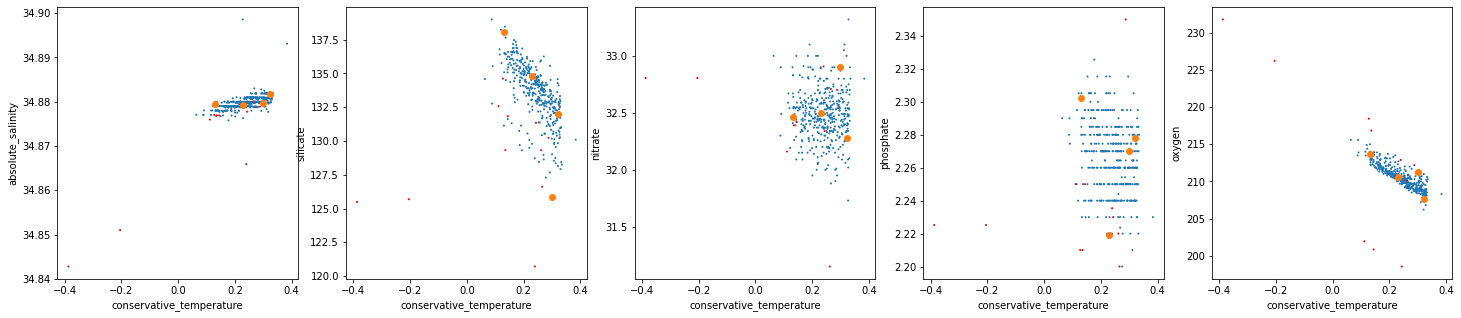

,conservative_temperature,absolute_salinity,silicate,nitrate,phosphate,oxygen,watermass_name
0,0.130915,34.879564,138.083619,32.460148,2.302207,213.684497,AABW_0
1,0.299621,34.879749,125.860000,32.900000,2.270000,211.300000,AABW_1
2,0.229832,34.879355,134.810239,32.502634,2.218892,210.595224,AABW_2
3,0.321891,34.881792,132.037178,32.280288,2.277775,207.597318,AABW_3


On water mass AAIW
Ranges: {'lat_min': -51.0, 'lat_max': -47.0, 'lon_min': -120.0, 'lon_max': 150.0, 'sig0_min': 27.01, 'sig0_max': 27.1}


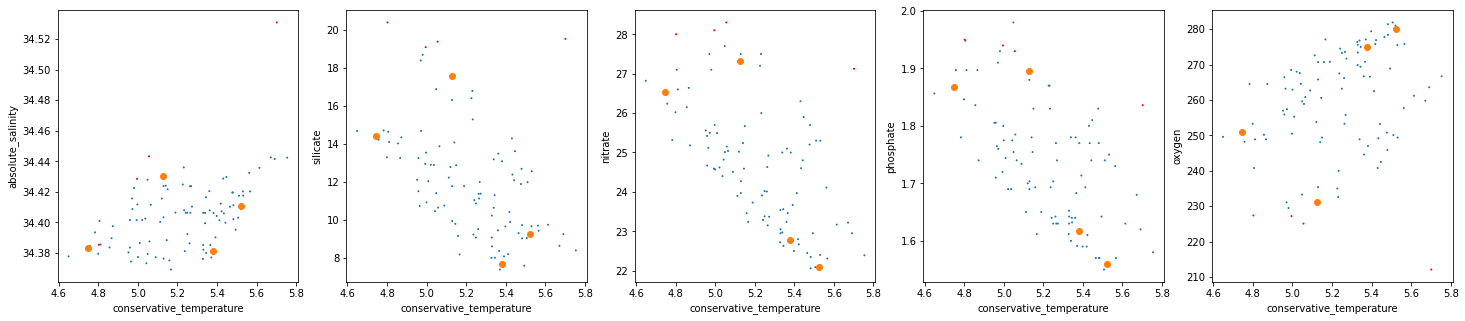

,conservative_temperature,absolute_salinity,silicate,nitrate,phosphate,oxygen,watermass_name
0,5.522635,34.411023,9.254778,22.099734,1.559665,280.023526,AAIW_0
1,5.126690,34.430319,17.594417,27.332754,1.895087,231.303846,AAIW_1
2,5.379608,34.381069,7.671507,22.771680,1.617050,274.845322,AAIW_2
3,4.746782,34.383586,14.402697,26.529277,1.867655,251.041861,AAIW_3


On water mass LCDW
Ranges: {'lat_min': -64.0, 'lat_max': -58.0, 'lon_min': -120.0, 'lon_max': 150.0, 'sig4_min': 45.84, 'sig4_max': 46.04}


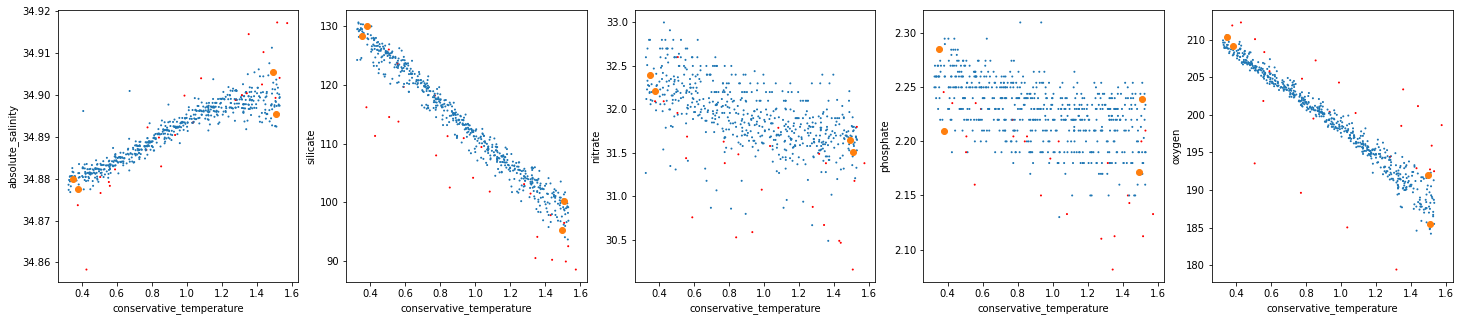

,conservative_temperature,absolute_salinity,silicate,nitrate,phosphate,oxygen,watermass_name
0,1.508314,34.895489,100.298979,31.509173,2.239527,185.484643,LCDW_0
1,0.349502,34.879939,128.334474,32.396399,2.285619,210.295030,LCDW_1
2,1.493431,34.905471,95.366717,31.644765,2.171915,191.935615,LCDW_2
3,0.378388,34.877648,130.061766,32.213418,2.209806,209.097096,LCDW_3


On water mass NPIW
Ranges: {'lat_min': 36.0, 'lat_max': 40.0, 'lon_min': 150.0, 'lon_max': 170.0, 'sig0_min': 26.6, 'sig0_max': 27.0, 'ox_min': 0, 'ox_max': 150.0}


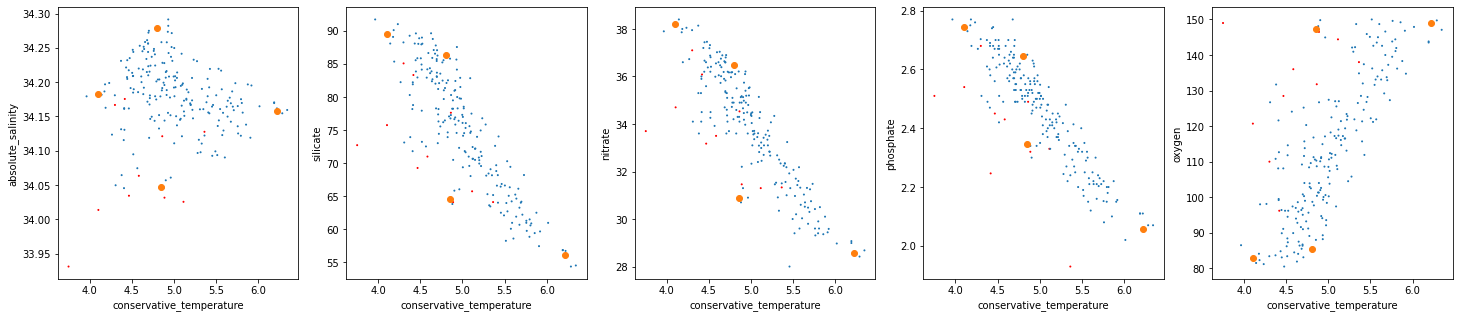

,conservative_temperature,absolute_salinity,silicate,nitrate,phosphate,oxygen,watermass_name
0,4.852202,34.047705,64.533845,30.902660,2.346433,147.244256,NPIW_0
1,4.802489,34.279408,86.299896,36.479378,2.647128,85.529734,NPIW_1
2,6.222141,34.157633,56.116734,28.587386,2.057025,149.004730,NPIW_2
3,4.100894,34.182974,89.489076,38.211454,2.745324,82.926733,NPIW_3


On water mass PDW1
Ranges: {'lat_min': 39.0, 'lat_max': 51.0, 'lon_min': -170.0, 'lon_max': -133.0, 'sig0_min': 27.6, 'sig0_max': 200, 'sig2_min': 0, 'sig2_max': 36.96}


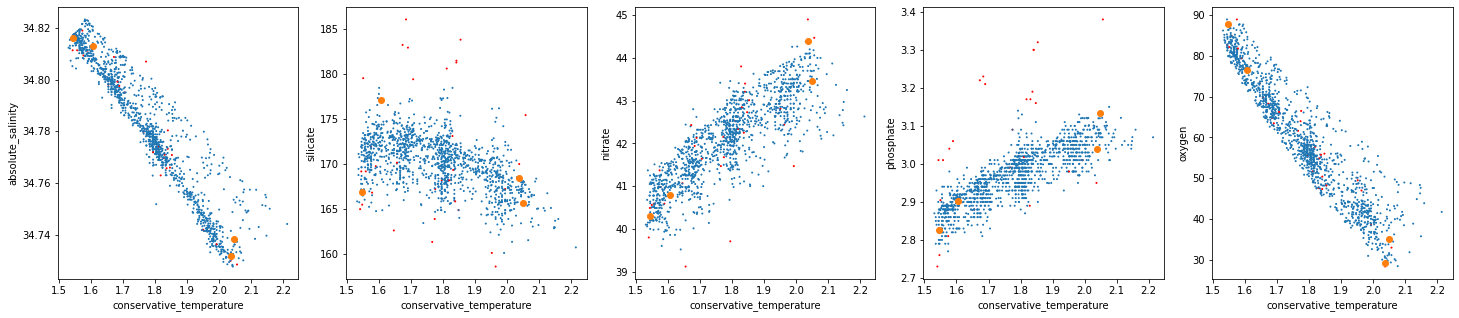

,conservative_temperature,absolute_salinity,silicate,nitrate,phosphate,oxygen,watermass_name
0,2.048851,34.738477,165.651877,43.449524,3.134757,35.065972,PDW1_0
1,1.606045,34.812846,177.070056,40.803456,2.903294,76.438478,PDW1_1
2,2.037144,34.731860,168.400000,44.400000,3.040000,29.300000,PDW1_2
3,1.545778,34.816158,166.871501,40.311885,2.826874,87.675928,PDW1_3


On water mass PDW2-3
Ranges: {'lat_min': 39.0, 'lat_max': 51.0, 'lon_min': -170.0, 'lon_max': -133.0, 'sig2_min': 36.96, 'sig2_max': 200, 'sig4_min': 0, 'sig4_max': 45.88}


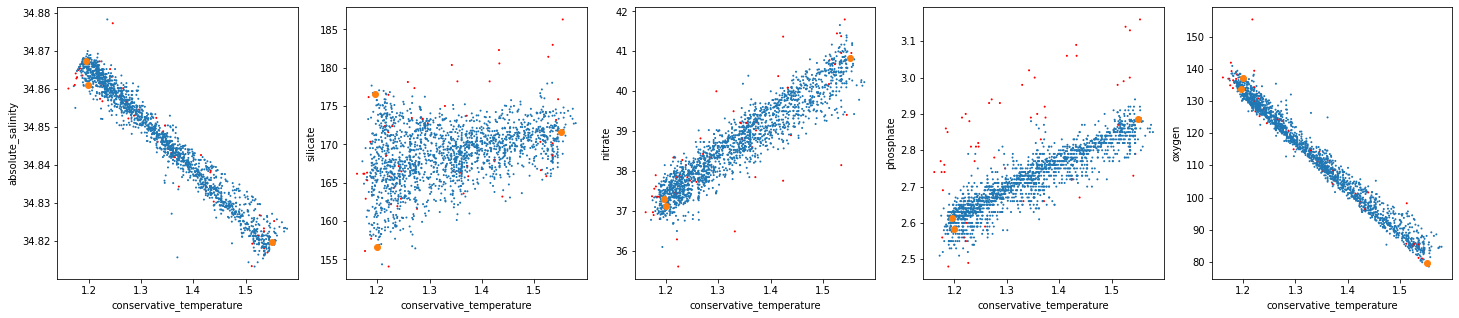

,conservative_temperature,absolute_salinity,silicate,nitrate,phosphate,oxygen,watermass_name
0,1.551030,34.819681,171.676808,40.845977,2.885309,79.799542,PDW2-3_0
1,1.195686,34.867235,176.647828,37.309763,2.614612,133.590201,PDW2-3_1
2,1.199860,34.861031,156.579763,37.117105,2.582614,137.219836,PDW2-3_2


On water mass UCDW
Ranges: {'lat_min': -50.0, 'lat_max': -45.0, 'lon_min': -120.0, 'lon_max': 150.0, 'sig2_min': 36.96, 'sig2_max': 200, 'sig4_min': 0, 'sig4_max': 45.84}


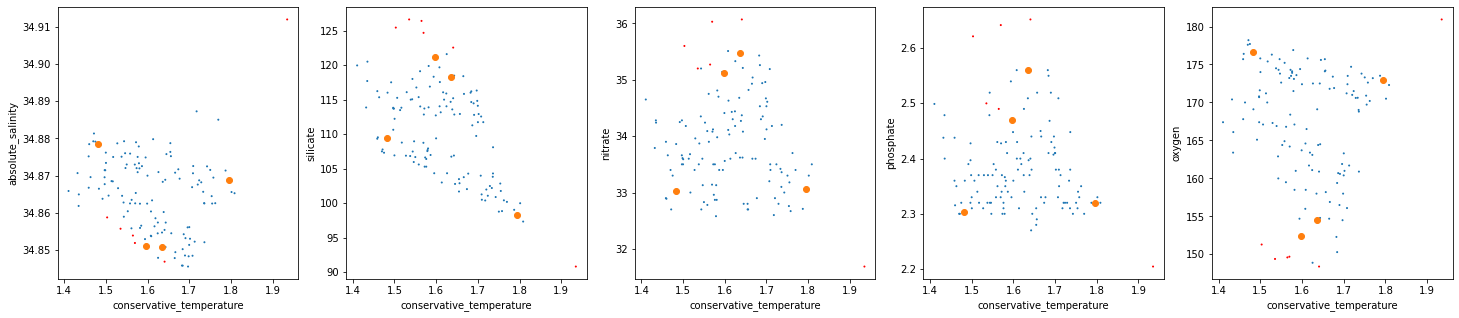

,conservative_temperature,absolute_salinity,silicate,nitrate,phosphate,oxygen,watermass_name
0,1.795089,34.868770,98.324295,33.060795,2.319507,173.004930,UCDW_0
1,1.597238,34.851154,121.228592,35.124918,2.470275,152.364303,UCDW_1
2,1.481871,34.878464,109.413813,33.022763,2.303627,176.676850,UCDW_2
3,1.635395,34.850950,118.368925,35.472788,2.559733,154.547551,UCDW_3


,conservative_temperature,absolute_salinity,silicate,nitrate,phosphate,oxygen,watermass_name
0,0.130915,34.879564,138.083619,32.460148,2.302207,213.684497,AABW_0
1,0.299621,34.879749,125.860000,32.900000,2.270000,211.300000,AABW_1
2,0.229832,34.879355,134.810239,32.502634,2.218892,210.595224,AABW_2
3,0.321891,34.881792,132.037178,32.280288,2.277775,207.597318,AABW_3
0,5.522635,34.411023,9.254778,22.099734,1.559665,280.023526,AAIW_0
1,5.126690,34.430319,17.594417,27.332754,1.895087,231.303846,AAIW_1
2,5.379608,34.381069,7.671507,22.771680,1.617050,274.845322,AAIW_2
3,4.746782,34.383586,14.402697,26.529277,1.867655,251.041861,AAIW_3
0,1.508314,34.895489,100.298979,31.509173,2.239527,185.484643,LCDW_0
1,0.349502,34.879939,128.334474,32.396399,2.285619,210.295030,LCDW_1


In [6]:
from py_pcha import PCHA
import scipy 
from scipy import spatial
from IPython.display import display, HTML


def flag_outliers(features, n_neighbors=20, zscore_threshold=2):
    #Features is observations X features
    #Do a process of removing outliers; if the average distance of a point to
    # its nearest N neighbors is more than stdev number of standard deviations from
    # the mean, flag it as an outlier.
    #I tried the Extreme Studentized Deviate but it wasn't behaving very
    # predictably. I guess the distribution of neighbor distances is
    # exponential-ish rather than normal.
    pairwise_distances = scipy.spatial.distance.squareform(
        scipy.spatial.distance.pdist(X=features, metric="euclidean"))
    avg_dist_to_nn = np.mean(
        np.sort(pairwise_distances, axis=-1)[:,1:n_neighbors+1], axis=-1)
    zscore_avgdisttonn = (avg_dist_to_nn - np.mean(avg_dist_to_nn))/np.std(
                          avg_dist_to_nn)
    #plt.hist(zscore_avgdisttonn, bins=100)
    #plt.show()
    anomalous_indices = np.abs(zscore_avgdisttonn) > zscore_threshold
    return anomalous_indices


def run_archetype_analysis(df, num_endmembers):
    np.random.seed(1234) #fix seed for reproducibility of results
    all_features = np.array([np.array(df["standardized_"+col])
                      for col in ARCH_ANALYSIS_FEATURES]).transpose((1,0))
    all_origspace_features = np.array([np.array(df[col]) for col in
                                   ALL_FEATURES_TO_AVERAGE]).transpose((1,0))

    outliers = flag_outliers(all_features)
    features = all_features[outliers==False]
    origspace_features = all_origspace_features[outliers==False]

    XC, S, C, SSE, varexpl = PCHA(X=features.T, noc=num_endmembers,
                                  verbose=False)
    archetype_features = np.array(XC).T #becomes archtetypes X features
    obs_combos_giving_archetypes = np.array(C).T #archetypes X obs combos

    origspace_archetypes = obs_combos_giving_archetypes@origspace_features

    #Make scatterplots
    fig,ax = plt.subplots(nrows=1, ncols=len(ARCH_ANALYSIS_FEATURES)-1,
                          figsize=(25,5))
    pltnum = 0
    for featureidx1 in [0]:#range(len(ALL_FEATURES_TO_AVERAGE)):
        for featureidx2 in range(featureidx1+1, len(ALL_FEATURES_TO_AVERAGE)):
            if ((ALL_FEATURES_TO_AVERAGE[featureidx1]
                 in ARCH_ANALYSIS_FEATURES) and
                (ALL_FEATURES_TO_AVERAGE[featureidx2]
                 in ARCH_ANALYSIS_FEATURES)):
                plt.sca(ax[pltnum])
                plt.scatter(all_origspace_features[:,featureidx1],
                            all_origspace_features[:,featureidx2],
                            c=[("red" if x==True else "C0") for x in outliers],
                            s=1)
                plt.scatter(origspace_archetypes[:,featureidx1],
                            origspace_archetypes[:,featureidx2],
                            color="C1")
                plt.xlabel(ALL_FEATURES_TO_AVERAGE[featureidx1])
                plt.ylabel(ALL_FEATURES_TO_AVERAGE[featureidx2]) 
                pltnum += 1
    plt.show()

    return pandas.DataFrame(dict([(colname, origspace_archetypes[:,idx])
                        for idx,colname in enumerate(ALL_FEATURES_TO_AVERAGE)]))
    

#num_archetypes is not really a filter condition but this is the easiest
# place to store that feature
filter_conditions = {
    "AAIW": {"lat_min":-51.0, "lat_max":-47.0,
             "lon_min":-120.0, "lon_max":150.0,
             "sig0_min":27.01, "sig0_max":27.1,
             "num_archetypes":4},
    "NPIW": {"lat_min":36.0, "lat_max":40.0, 
             "lon_min":150.0, "lon_max":170.0,
             "sig0_min":26.6, "sig0_max":27.0,
             "ox_min":0, "ox_max":150.0,
             "num_archetypes":4},
    "UCDW": {"lat_min":-50.0, "lat_max":-45.0, 
             "lon_min":-120.0, "lon_max":150.0,
             "sig2_min":36.96, "sig2_max":200,
             "sig4_min":0, "sig4_max":45.84,
             "num_archetypes":4},
    "LCDW": {"lat_min":-64.0, "lat_max":-58.0, 
             "lon_min":-120.0, "lon_max":150.0,
             "sig4_min":45.84, "sig4_max":46.04,
             "num_archetypes":4},
    "AABW": {"lat_min":-60.0, "lat_max":-50.0, 
             "lon_min":-120.0, "lon_max":150.0,
             "sig4_min":46.04, "sig4_max":200,
             "num_archetypes":4},
    "PDW1": {"lat_min":39.0, "lat_max":51.0, 
             "lon_min":-170.0, "lon_max":-133.0,
             "sig0_min":27.6, "sig0_max":200,
             "sig2_min":0, "sig2_max":36.96,
             'num_archetypes':4},
    "PDW2-3": {"lat_min":39.0, "lat_max":51.0, 
             "lon_min":-170.0, "lon_max":-133.0,
             "sig2_min":36.96, "sig2_max":200,
             "sig4_min":0, "sig4_max":45.88,
             "num_archetypes":3}
}

def filter_rows(df, lat_min, lat_max, lon_min, lon_max,
                sig0_min=0, sig0_max=np.inf, 
                sig2_min=0, sig2_max=np.inf,
                sig4_min=0, sig4_max=np.inf,
                ox_min=0, ox_max=np.inf):
  return df[(df["latitude"] >= lat_min) &
            (df["latitude"] <= lat_max) &
            (df["longitude"] >= lon_min) &
            (df["longitude"] <= lon_max) &
            (df["sigma0"] >= sig0_min) &
            (df["sigma0"] <= sig0_max) &
            (df["sigma2"] >= sig2_min) &
            (df["sigma2"] <= sig2_max) &
            (df["sigma4"] >= sig4_min) &
            (df["sigma4"] <= sig4_max) &
            (df["oxygen"] >= ox_min) &
            (df["oxygen"] <= ox_max) 
            ]

watermass_to_archetypes = {}

for watermass in sorted(filter_conditions.keys()):
  print("On water mass", watermass)
  num_archetypes = filter_conditions[watermass]['num_archetypes']
  del filter_conditions[watermass]['num_archetypes']
  print("Ranges:", filter_conditions[watermass])
  watermass_rows = filter_rows(df=df, **filter_conditions[watermass])
  watermass_archetypes = run_archetype_analysis(
      df=watermass_rows,
      num_endmembers=num_archetypes)
  watermass_archetypes["watermass_name"] = [watermass+"_"+str(i)
                                            for i in range(num_archetypes)]
  watermass_to_archetypes[watermass] = watermass_archetypes
  display(watermass_archetypes)

full_watermass_df = pandas.concat([watermass_to_archetypes[watermass]
                          for watermass in sorted(watermass_to_archetypes.keys())])

display(full_watermass_df)

In [9]:
full_watermass_df.to_csv("GP15_intermediateanddeep_endmemberswithsubtypes.csv",
                         columns=["watermass_name"]+ALL_FEATURES_TO_AVERAGE,
                         index=False)